In [1]:
# ! pip install tensorflow-datasets
# ! pip install "protobuf<4.21,>=3.20.3"



In [2]:
# ! pip uninstall tensorflow-datasets
# ! pip install tensorflow-datasets


In [3]:
# ! pip install --upgrade tensorflow-datasets

In [4]:
import sys
import os



In [62]:
import tensorflow as tf
import os
import glob


def parse_function(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # image = image / 255.0  # Normalize to [0, 1]
    # print("Image data type:", image.dtype)
    image = tf.cast(image, tf.uint8)
    # print("Image data type:", image.dtype)

    return image

def load_wider_face_dataset(base_directory, split='train'):
    assert split in ['train', 'test', 'val'], "Split must be 'train', 'test', or 'val'"
    split_directory = os.path.join(base_directory, split)
    print(f"split dir: {split_directory}")
    
    # Recursively find JPEG images in subfolders
    image_paths = glob.glob(os.path.join(split_directory, '**', '*.jpg'), recursive=True)
    print(f"image paths: {len(image_paths)}")
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return image_dataset


def prepare_for_training(ds, batch_size=32, buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


In [67]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

# Choose based on your requirement. For higher accuracy, use Large, for efficiency, use Small
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# or base_model = MobileNetV3Small(...)


12683000/12683000 [==============================] - 1s 0us/step


In [102]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.models import Model

MAX_FACES = 10

# set a max number of faces
# trim any faces that are below a conficence threshold
# refactor how mtcnn data is read to grab n most confident faces
   # set the confidences and info to zero for faces that are below the threshold

# Freeze the convolutional base to prevent its weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for face and landmark detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Output layer for face detection (assuming binary classification: face/no face)
confidences = Dense(MAX_FACES, activation='sigmoid', name='detection')(x)

# Predict bounding boxes for each detection
bounding_boxes = Dense(MAX_FACES * 4, activation='linear', name='bounding_boxes')(x)
bounding_boxes = Reshape((MAX_FACES, 4))(bounding_boxes)

# Predict landmarks for each detection
landmarks = Dense(MAX_FACES * 10, activation='linear', name='landmarks')(x)
landmarks = Reshape((MAX_FACES, 10))(landmarks)

model = Model(inputs=base_model.input, outputs=[confidences, bounding_boxes, landmarks])


In [63]:
base_directory = 'C:/Users/bridg/tensorflow_datasets/my_wider_face'

train_dataset = load_wider_face_dataset(base_directory, 'train')
train_dataset = prepare_for_training(train_dataset)

test_dataset = load_wider_face_dataset(base_directory, 'test')
test_dataset = prepare_for_training(test_dataset)

val_dataset = load_wider_face_dataset(base_directory, 'val')
val_dataset = prepare_for_training(val_dataset)



split dir: C:/Users/bridg/tensorflow_datasets/my_wider_face\train
image paths: 12880
split dir: C:/Users/bridg/tensorflow_datasets/my_wider_face\test
image paths: 16097
split dir: C:/Users/bridg/tensorflow_datasets/my_wider_face\val
image paths: 3226


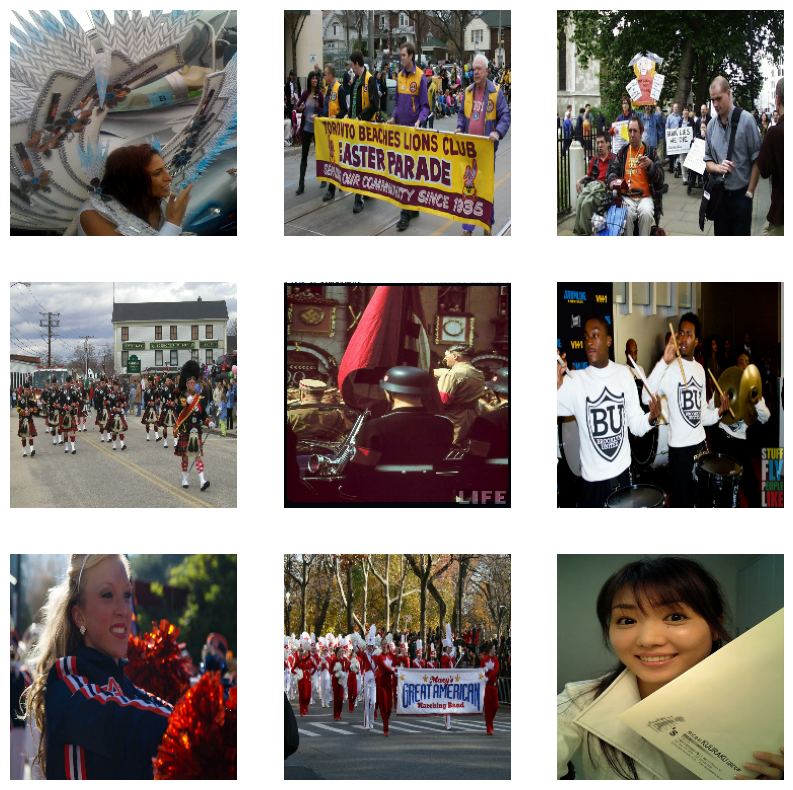

In [64]:
import matplotlib.pyplot as plt
import tensorflow as tf

def show_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

# Assuming `dataset` is your TensorFlow dataset
show_images(train_dataset)


In [85]:
def format_output(confidences, landmarks):
    

    formatted_output = []
    
    # Assume each row in confidences and landmarks corresponds to a detected face
    for i in range(len(confidences)):
        # Extract confidence and reshape for single value
        confidence = confidences[i][0]
        
        # Extract landmarks for current face
        kp = landmarks[i]
        keypoints = {
            'left_eye': (kp[0], kp[1]),
            'right_eye': (kp[2], kp[3]),
            'nose': (kp[4], kp[5]),
            'mouth_left': (kp[6], kp[7]),
            'mouth_right': (kp[8], kp[9])
        }
        
        # Placeholder for the box since it's not provided in your output example
        # You will need to add your logic here to compute or extract the box coordinates
        box = [0, 0, 0, 0]  # Example placeholder
        
        formatted_output.append({
            'box': box,
            'confidence': float(confidence),
            'keypoints': keypoints
        })
    
    return formatted_output




In [113]:
def detections_to_tensors(detections):
    """
    Convert a list of detection dictionaries to separate tensors for
    confidences, bounding boxes, and landmarks.
    
    Args:
    - detections: A list of dictionaries, each containing 'confidence', 'box', and 'keypoints'
    
    Returns:
    - A tuple of tensors: (confidences_tensor, bounding_boxes_tensor, landmarks_tensor)
    """
    confidences = []
    bounding_boxes = []
    landmarks = []
    

    for i in range(MAX_FACES):
        print(f"len detections: {len(detections), i}")
        if len(detections) <= i:
            print("here")
            confidences.append(0.0)
            bounding_boxes.append([0, 0, 0, 0])
            landmarks.append([0] * 10)
            break
        
        detection = detections[i]
        print(f"detection: {detection}")
  
        # Extract confidence
        confidences.append(detection['confidence'])
        
        # Extract bounding box
        bounding_boxes.append(detection['box'])
        
        # Extract and flatten landmarks
        kp = detection['keypoints']
        landmarks_flattened = [
            kp['left_eye'][0], kp['left_eye'][1],
            kp['right_eye'][0], kp['right_eye'][1],
            kp['nose'][0], kp['nose'][1],
            kp['mouth_left'][0], kp['mouth_left'][1],
            kp['mouth_right'][0], kp['mouth_right'][1],
        ]
        landmarks.append(landmarks_flattened)
    
    # Convert lists to tensors
    confidences_tensor = tf.convert_to_tensor(confidences, dtype=tf.float32)
    bounding_boxes_tensor = tf.convert_to_tensor(bounding_boxes, dtype=tf.float32)
    landmarks_tensor = tf.convert_to_tensor(landmarks, dtype=tf.float32)
    
    return confidences_tensor, bounding_boxes_tensor, landmarks_tensor

In [115]:
import numpy as np
import time

model_dir = os.path.abspath('rooster-deepface/deepface/detectors')
if model_dir not in sys.path:
    sys.path.append(model_dir)

from deepface.detectors import FaceDetector
from mtcnn import MTCNN

mtcnn_detector = MTCNN()
model.compile(optimizer='adam',
              loss={'detection': 'binary_crossentropy', 'bounding_box': 'mean_squared_error', 'landmarks': 'mean_squared_error'},
              metrics={'detection': 'accuracy', 'landmarks': 'mse'})



detector_backend = 'mtcnn'
align = True
face_detector = FaceDetector.build_model(detector_backend)


# Iterate over each image in the batch
for images in train_dataset.take(1):
    img_array = images.numpy()  # Assuming 'images' is a batch of images


    start_time = time.time()
    confidences, bounding_box, landmarks = model.predict(images)
    print(f"Time taken by mobile net: {time.time() - start_time:.2f} seconds")
    print(f"predictions: {confidences.shape}")
    print(f"landmarks: {landmarks.shape}")
    print(f"bounding box: {bounding_box.shape}")

    labels = []

    # Process each image in the batch individually
    batch_detections = []

    start_time = time.time()
    for img in img_array:
        detections = []
        # Detect faces
        face_objs = FaceDetector.detect_faces(face_detector=face_detector, detector_backend=detector_backend, img=img, align=align)
        if len(face_objs) == 0:
            # No faces detected
            continue
        else:
            for face_obj in face_objs:
                detection = {}
                detection['confidence'] = face_obj['confidence']
                detection['box'] = face_obj['box']
                detection['keypoints'] = face_obj['keypoints']
                detections.append(detection)


        batch_detections.append(detections)
    print(f"Time taken by mtcnn: {time.time() - start_time:.2f} seconds")
    print(f"batch detections: {len(batch_detections)}")

    confidences_labels, bounding_boxes_labels, landmarks_labels = detections_to_tensors(batch_detections)
    print(f"confidences labels: {confidences_labels.shape}")
    print(f"bounding_boxes labels: {bounding_boxes_labels.shape}")
    print(f"landmarks labels: {landmarks_labels.shape}")

    raise Exception("Stop here")


1/1 [==============================] - 2s 2s/step
Time taken by mobile net: 2.25 seconds
predictions: (32, 10)
landmarks: (32, 10, 10)
bounding box: (32, 10, 4)
1/1 [==============================] - 0s 29ms/step
face objs: [(array([[[ 61,  49,  37],
        [ 74,  67,  59],
        [ 80,  78,  72],
        ...,
        [ 78,  67,  63],
        [ 43,  38,  32],
        [ 69,  64,  54]],

       [[ 63,  51,  39],
        [ 73,  64,  55],
        [ 84,  79,  73],
        ...,
        [ 96,  79,  76],
        [ 58,  49,  44],
        [ 51,  44,  38]],

       [[ 63,  53,  43],
        [ 72,  64,  53],
        [ 90,  81,  73],
        ...,
        [150, 129, 128],
        [ 59,  43,  40],
        [ 42,  31,  28]],

       ...,

       [[ 42,  40,  47],
        [ 60,  51,  52],
        [111,  95,  90],
        ...,
        [168, 138, 130],
        [138, 106,  93],
        [107,  73,  55]],

       [[ 51,  57,  79],
        [ 45,  41,  55],
        [ 96,  85,  89],
        ...,
        [166,

KeyboardInterrupt: 

detections: [{'box': [0, 0, 0, 0], 'confidence': 0.6748742461204529, 'keypoints': {'left_eye': (-0.73534316, 1.0557722), 'right_eye': (0.52684826, 0.087934226), 'nose': (-3.246008, 1.0227318), 'mouth_left': (-0.070850015, -2.3160443), 'mouth_right': (-0.30880076, -1.1930287)}}, {'box': [0, 0, 0, 0], 'confidence': 0.662733256816864, 'keypoints': {'left_eye': (-0.46789718, 1.1963675), 'right_eye': (2.265353, -0.6215133), 'nose': (-0.5917515, 1.2513131), 'mouth_left': (0.2775367, -1.4230711), 'mouth_right': (1.2971957, -0.44156244)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7612593173980713, 'keypoints': {'left_eye': (0.02128604, -0.1444282), 'right_eye': (0.9780227, -0.062327206), 'nose': (-0.7947538, -0.24396026), 'mouth_left': (-0.80730915, -0.39987165), 'mouth_right': (-0.243312, -0.40480956)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7261316776275635, 'keypoints': {'left_eye': (0.19468048, -0.12398183), 'right_eye': (0.3937503, 0.80306935), 'nose': (-2.1229439, 1.3268812), 'mouth_left': (0.37262142, -1.9344918), 'mouth_right': (-0.009756461, -1.6687906)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6112657189369202, 'keypoints': {'left_eye': (-1.4376838, -0.13405369), 'right_eye': (0.9454672, -1.0054946), 'nose': (-1.2796795, 0.7237004), 'mouth_left': (0.17286426, -1.6581006), 'mouth_right': (-0.051362723, -1.3805331)}}, {'box': [0, 0, 0, 0], 'confidence': 0.43956613540649414, 'keypoints': {'left_eye': (0.25797448, 0.10887772), 'right_eye': (1.742039, 0.047320604), 'nose': (-2.6878638, 1.2664157), 'mouth_left': (-0.6220403, -0.83493066), 'mouth_right': (0.64588857, 0.46361288)}}, {'box': [0, 0, 0, 0], 'confidence': 0.45596566796302795, 'keypoints': {'left_eye': (-0.48110017, -0.054014698), 'right_eye': (0.81094515, 0.20306033), 'nose': (-1.3471062, 1.043869), 'mouth_left': (-0.45052552, -0.91372937), 'mouth_right': (0.38716, 0.31470937)}}, {'box': [0, 0, 0, 0], 'confidence': 0.3327430784702301, 'keypoints': {'left_eye': (-0.8909421, -0.10495494), 'right_eye': (0.78482074, 0.22628881), 'nose': (-1.6374907, 1.1686583), 'mouth_left': (-0.23000596, -2.0365424), 'mouth_right': (0.8789638, -1.7195067)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6887228488922119, 'keypoints': {'left_eye': (-1.0079868, -0.5448346), 'right_eye': (0.47385538, 0.15579048), 'nose': (-2.1194272, 0.955676), 'mouth_left': (1.0999314, -1.1255065), 'mouth_right': (-0.1230492, -1.2754079)}}, {'box': [0, 0, 0, 0], 'confidence': 0.26138707995414734, 'keypoints': {'left_eye': (-2.0817835, 0.8285319), 'right_eye': (2.9650826, -0.3966746), 'nose': (-1.7730532, -0.1268357), 'mouth_left': (-0.38797796, -2.1397014), 'mouth_right': (0.32318836, -1.3868986)}}, {'box': [0, 0, 0, 0], 'confidence': 0.44208064675331116, 'keypoints': {'left_eye': (-1.4223311, 0.5183261), 'right_eye': (0.92046547, 0.36272493), 'nose': (-2.7218766, 0.8806597), 'mouth_left': (-0.5534946, -1.6414999), 'mouth_right': (0.059157312, -0.39896873)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6162046194076538, 'keypoints': {'left_eye': (-0.7164855, -0.3229618), 'right_eye': (1.4644511, 1.094023), 'nose': (-1.5458885, 1.6753731), 'mouth_left': (0.7595, -1.9355742), 'mouth_right': (0.60619366, -1.6566324)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5007038712501526, 'keypoints': {'left_eye': (-0.8981524, 0.2851976), 'right_eye': (2.0749166, -0.25473645), 'nose': (-2.055313, 0.47512257), 'mouth_left': (1.4844327, -1.8432792), 'mouth_right': (0.45787084, -0.9326553)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6677223443984985, 'keypoints': {'left_eye': (0.26903564, 0.7264953), 'right_eye': (2.31631, -0.20283666), 'nose': (-2.39993, 0.3170562), 'mouth_left': (0.31730622, -2.4194305), 'mouth_right': (-0.6484506, -1.0925173)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6510516405105591, 'keypoints': {'left_eye': (0.4056281, -0.46656206), 'right_eye': (0.69371736, 0.6295694), 'nose': (-1.0539335, 1.3557016), 'mouth_left': (1.024978, -1.1571667), 'mouth_right': (0.27583224, -2.5201042)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7634016871452332, 'keypoints': {'left_eye': (-0.75844675, 1.5011079), 'right_eye': (1.3022864, 0.034379803), 'nose': (-2.9678924, 0.88230073), 'mouth_left': (-0.18527794, -2.5490048), 'mouth_right': (-1.0788337, -1.2654924)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8083810210227966, 'keypoints': {'left_eye': (0.12408441, 0.3159696), 'right_eye': (1.3021337, -0.24238002), 'nose': (-1.8894472, 0.57253164), 'mouth_left': (-0.19124562, -1.569947), 'mouth_right': (1.5067283, -2.5788105)}}, {'box': [0, 0, 0, 0], 'confidence': 0.22409279644489288, 'keypoints': {'left_eye': (-0.7106621, 0.31891042), 'right_eye': (2.041935, 0.123496056), 'nose': (-0.604337, 0.05501657), 'mouth_left': (-0.46236682, -0.93050236), 'mouth_right': (-0.5908302, -0.50541604)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6429218649864197, 'keypoints': {'left_eye': (0.8314836, 0.5336419), 'right_eye': (0.994622, -0.55376697), 'nose': (-1.3113993, 1.2257055), 'mouth_left': (0.20948464, -1.9082013), 'mouth_right': (-0.9077283, -0.65188754)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8969323039054871, 'keypoints': {'left_eye': (-0.3491745, -0.77068746), 'right_eye': (0.9141724, 1.1773255), 'nose': (-1.7386501, -0.014859706), 'mouth_left': (-0.6711997, -1.1837105), 'mouth_right': (-0.03721135, -1.170072)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7750704288482666, 'keypoints': {'left_eye': (-0.35558227, 3.3539774), 'right_eye': (1.1430913, -0.8557833), 'nose': (-0.5160624, 0.5252401), 'mouth_left': (1.4499307, -0.18910882), 'mouth_right': (-0.93902135, -0.7960827)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8036332726478577, 'keypoints': {'left_eye': (-0.57090366, 0.19525385), 'right_eye': (1.4522698, 0.53823686), 'nose': (-2.520535, 0.7806097), 'mouth_left': (-0.18835843, -2.103738), 'mouth_right': (-0.12026468, -1.3040837)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7937236428260803, 'keypoints': {'left_eye': (-0.1102094, -0.13833255), 'right_eye': (0.16710642, 0.64867634), 'nose': (-1.1720443, 0.01630336), 'mouth_left': (-0.02336435, -1.401716), 'mouth_right': (0.79992783, -1.1465005)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5418329834938049, 'keypoints': {'left_eye': (0.3170822, 0.8031453), 'right_eye': (0.122058064, 0.4389605), 'nose': (-0.75579894, 1.3108217), 'mouth_left': (-1.5569513, -0.37622035), 'mouth_right': (0.6614735, -0.579587)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4066491723060608, 'keypoints': {'left_eye': (-1.342586, 0.24617955), 'right_eye': (0.59812474, 1.2999786), 'nose': (-1.0304201, 0.7791197), 'mouth_left': (0.1895448, -0.6043046), 'mouth_right': (0.23198086, -1.0792239)}}, {'box': [0, 0, 0, 0], 'confidence': 0.6315093040466309, 'keypoints': {'left_eye': (-0.37820798, 0.30032268), 'right_eye': (-0.36450517, 0.16434371), 'nose': (-2.6078386, 0.9522995), 'mouth_left': (0.2733035, -2.0981436), 'mouth_right': (-0.8825002, -2.2394173)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7679756283760071, 'keypoints': {'left_eye': (-0.33176193, -0.47868887), 'right_eye': (0.97607106, 0.4909075), 'nose': (-1.8264654, 1.1663303), 'mouth_left': (0.40391463, -0.93893725), 'mouth_right': (0.09386648, -0.78133535)}}, {'box': [0, 0, 0, 0], 'confidence': 0.7475014925003052, 'keypoints': {'left_eye': (-0.3774311, 0.7491859), 'right_eye': (0.17327793, 0.40230832), 'nose': (-1.2746692, -0.17657539), 'mouth_left': (0.14843279, -0.39118445), 'mouth_right': (0.778028, -0.34455544)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4190661609172821, 'keypoints': {'left_eye': (-0.19434883, 0.16757837), 'right_eye': (1.592175, -0.61957973), 'nose': (-1.334296, 0.31065306), 'mouth_left': (-0.35070005, -1.1454306), 'mouth_right': (-0.43045896, -0.20537475)}}, {'box': [0, 0, 0, 0], 'confidence': 0.5351845622062683, 'keypoints': {'left_eye': (0.8510463, 0.9252754), 'right_eye': (0.62585545, -0.27070066), 'nose': (-1.6858616, 0.35231534), 'mouth_left': (-0.21385603, -1.3673733), 'mouth_right': (0.38269535, -0.80226666)}}, {'box': [0, 0, 0, 0], 'confidence': 0.4229130446910858, 'keypoints': {'left_eye': (-0.13112305, -0.53981864), 'right_eye': (0.90451014, 0.10645044), 'nose': (-3.051505, 0.60885894), 'mouth_left': (-1.2859052, -1.5442549), 'mouth_right': (-0.57167697, 0.5641434)}}, {'box': [0, 0, 0, 0], 'confidence': 0.8828781247138977, 'keypoints': {'left_eye': (-0.18554488, -1.1352165), 'right_eye': (1.1226485, 1.0341074), 'nose': (-2.974544, 1.0071846), 'mouth_left': (-0.60380226, -1.4423974), 'mouth_right': (0.17357188, -0.8182271)}}]


labels: [[], [{'box': [24, 30, 18, 27], 'confidence': 0.9997275471687317, 'keypoints': {'left_eye': (30, 40), 'right_eye': (38, 42), 'nose': (34, 46), 'mouth_left': (28, 49), 'mouth_right': (37, 51)}}, {'box': [145, 42, 20, 30], 'confidence': 0.9990147352218628, 'keypoints': {'left_eye': (151, 53), 'right_eye': (160, 54), 'nose': (154, 60), 'mouth_left': (150, 65), 'mouth_right': (157, 66)}}, {'box': [73, 47, 19, 28], 'confidence': 0.9989433884620667, 'keypoints': {'left_eye': (80, 57), 'right_eye': (88, 59), 'nose': (84, 64), 'mouth_left': (79, 67), 'mouth_right': (87, 69)}}, {'box': [115, 52, 17, 28], 'confidence': 0.9985287189483643, 'keypoints': {'left_eye': (118, 62), 'right_eye': (126, 62), 'nose': (121, 67), 'mouth_left': (118, 72), 'mouth_right': (127, 72)}}, {'box': [178, 53, 17, 26], 'confidence': 0.9978204965591431, 'keypoints': {'left_eye': (181, 62), 'right_eye': (190, 63), 'nose': (185, 68), 'mouth_left': (181, 72), 'mouth_right': (189, 73)}}], [{'box': [81, 43, 17, 29], 'confidence': 0.973102331161499, 'keypoints': {'left_eye': (91, 53), 'right_eye': (97, 52), 'nose': (97, 59), 'mouth_left': (92, 65), 'mouth_right': (96, 65)}}, {'box': [129, 16, 20, 34], 'confidence': 0.9348683953285217, 'keypoints': {'left_eye': (133, 29), 'right_eye': (140, 26), 'nose': (136, 35), 'mouth_left': (138, 44), 'mouth_right': (142, 42)}}], [], [], [{'box': [92, 39, 14, 19], 'confidence': 0.998066246509552, 'keypoints': {'left_eye': (95, 45), 'right_eye': (103, 45), 'nose': (99, 51), 'mouth_left': (96, 54), 'mouth_right': (103, 53)}}, {'box': [179, 35, 15, 20], 'confidence': 0.9970511198043823, 'keypoints': {'left_eye': (182, 40), 'right_eye': (190, 40), 'nose': (185, 46), 'mouth_left': (183, 49), 'mouth_right': (190, 49)}}, {'box': [58, 40, 15, 23], 'confidence': 0.9963812828063965, 'keypoints': {'left_eye': (62, 49), 'right_eye': (70, 49), 'nose': (66, 54), 'mouth_left': (62, 57), 'mouth_right': (69, 57)}}, {'box': [29, 49, 14, 22], 'confidence': 0.9856202602386475, 'keypoints': {'left_eye': (34, 56), 'right_eye': (41, 57), 'nose': (38, 63), 'mouth_left': (33, 66), 'mouth_right': (39, 66)}}, {'box': [138, 35, 17, 28], 'confidence': 0.9763843417167664, 'keypoints': {'left_eye': (144, 46), 'right_eye': (152, 47), 'nose': (148, 53), 'mouth_left': (143, 56), 'mouth_right': (150, 57)}}], [], [{'box': [138, 38, 14, 20], 'confidence': 0.9882583022117615, 'keypoints': {'left_eye': (140, 45), 'right_eye': (147, 43), 'nose': (144, 49), 'mouth_left': (142, 53), 'mouth_right': (148, 51)}}, {'box': [35, 28, 15, 25], 'confidence': 0.9718230962753296, 'keypoints': {'left_eye': (39, 37), 'right_eye': (47, 38), 'nose': (43, 43), 'mouth_left': (39, 46), 'mouth_right': (45, 47)}}, {'box': [171, 36, 14, 25], 'confidence': 0.9571990370750427, 'keypoints': {'left_eye': (173, 46), 'right_eye': (180, 45), 'nose': (175, 52), 'mouth_left': (173, 56), 'mouth_right': (179, 55)}}, {'box': [101, 31, 15, 23], 'confidence': 0.942952573299408, 'keypoints': {'left_eye': (104, 39), 'right_eye': (112, 39), 'nose': (108, 45), 'mouth_left': (105, 49), 'mouth_right': (111, 49)}}, {'box': [74, 25, 16, 27], 'confidence': 0.871976375579834, 'keypoints': {'left_eye': (79, 36), 'right_eye': (87, 37), 'nose': (84, 42), 'mouth_left': (79, 46), 'mouth_right': (85, 46)}}], [], [{'box': [122, 45, 7, 11], 'confidence': 0.9735006093978882, 'keypoints': {'left_eye': (124, 50), 'right_eye': (128, 49), 'nose': (126, 52), 'mouth_left': (125, 54), 'mouth_right': (128, 54)}}, {'box': [87, 57, 9, 13], 'confidence': 0.9728569388389587, 'keypoints': {'left_eye': (90, 62), 'right_eye': (95, 63), 'nose': (92, 67), 'mouth_left': (89, 69), 'mouth_right': (93, 69)}}, {'box': [113, 101, 12, 16], 'confidence': 0.862289309501648, 'keypoints': {'left_eye': (116, 106), 'right_eye': (122, 106), 'nose': (119, 109), 'mouth_left': (116, 112), 'mouth_right': (121, 112)}}, {'box': [180, 36, 12, 17], 'confidence': 0.7790029644966125, 'keypoints': {'left_eye': (182, 42), 'right_eye': (186, 41), 'nose': (183, 45), 'mouth_left': (183, 49), 'mouth_right': (187, 48)}}, {'box': [39, 38, 11, 14], 'confidence': 0.7031712532043457, 'keypoints': {'left_eye': (44, 41), 'right_eye': (49, 42), 'nose': (47, 46), 'mouth_left': (43, 48), 'mouth_right': (47, 48)}}], [], [], [], [], [], [], [], [{'box': [12, 58, 22, 32], 'confidence': 0.9999390840530396, 'keypoints': {'left_eye': (23, 70), 'right_eye': (32, 70), 'nose': (31, 78), 'mouth_left': (25, 83), 'mouth_right': (31, 83)}}, {'box': [87, 56, 13, 21], 'confidence': 0.9996486902236938, 'keypoints': {'left_eye': (93, 63), 'right_eye': (99, 64), 'nose': (97, 69), 'mouth_left': (92, 72), 'mouth_right': (97, 72)}}, {'box': [116, 47, 11, 17], 'confidence': 0.9858732223510742, 'keypoints': {'left_eye': (119, 53), 'right_eye': (125, 53), 'nose': (122, 57), 'mouth_left': (120, 61), 'mouth_right': (124, 60)}}, {'box': [191, 43, 9, 13], 'confidence': 0.9697521328926086, 'keypoints': {'left_eye': (192, 49), 'right_eye': (196, 47), 'nose': (194, 51), 'mouth_left': (194, 54), 'mouth_right': (197, 53)}}], [{'box': [91, 113, 8, 10], 'confidence': 0.9931857585906982, 'keypoints': {'left_eye': (92, 116), 'right_eye': (97, 115), 'nose': (95, 118), 'mouth_left': (93, 121), 'mouth_right': (97, 120)}}], [], [], [], [{'box': [208, 54, 17, 18], 'confidence': 0.997380793094635, 'keypoints': {'left_eye': (211, 60), 'right_eye': (218, 59), 'nose': (213, 64), 'mouth_left': (212, 68), 'mouth_right': (218, 68)}}, {'box': [138, 27, 25, 28], 'confidence': 0.9966952800750732, 'keypoints': {'left_eye': (141, 37), 'right_eye': (150, 38), 'nose': (141, 43), 'mouth_left': (139, 49), 'mouth_right': (146, 49)}}, {'box': [34, 38, 18, 19], 'confidence': 0.9934418201446533, 'keypoints': {'left_eye': (36, 45), 'right_eye': (43, 45), 'nose': (37, 50), 'mouth_left': (37, 55), 'mouth_right': (43, 54)}}], [{'box': [29, 12, 37, 54], 'confidence': 0.9999991655349731, 'keypoints': {'left_eye': (53, 33), 'right_eye': (64, 34), 'nose': (65, 44), 'mouth_left': (51, 51), 'mouth_right': (62, 52)}}, {'box': [159, 23, 31, 50], 'confidence': 0.9999954700469971, 'keypoints': {'left_eye': (162, 42), 'right_eye': (169, 43), 'nose': (159, 53), 'mouth_left': (164, 62), 'mouth_right': (171, 62)}}], [], [], [], [{'box': [82, 60, 43, 70], 'confidence': 0.9998668432235718, 'keypoints': {'left_eye': (112, 88), 'right_eye': (124, 87), 'nose': (129, 98), 'mouth_left': (114, 113), 'mouth_right': (125, 111)}}, {'box': [48, 84, 16, 23], 'confidence': 0.9290136694908142, 'keypoints': {'left_eye': (55, 91), 'right_eye': (62, 91), 'nose': (60, 96), 'mouth_left': (56, 102), 'mouth_right': (61, 102)}}, {'box': [176, 170, 24, 45], 'confidence': 0.8331894278526306, 'keypoints': {'left_eye': (190, 187), 'right_eye': (198, 188), 'nose': (199, 196), 'mouth_left': (191, 206), 'mouth_right': (197, 206)}}], [{'box': [177, 34, 20, 28], 'confidence': 0.9993168115615845, 'keypoints': {'left_eye': (179, 45), 'right_eye': (188, 44), 'nose': (182, 51), 'mouth_left': (181, 56), 'mouth_right': (188, 55)}}, {'box': [9, 46, 19, 26], 'confidence': 0.999021053314209, 'keypoints': {'left_eye': (15, 54), 'right_eye': (24, 55), 'nose': (21, 61), 'mouth_left': (14, 64), 'mouth_right': (23, 64)}}, {'box': [84, 40, 15, 21], 'confidence': 0.998915433883667, 'keypoints': {'left_eye': (90, 48), 'right_eye': (97, 47), 'nose': (95, 53), 'mouth_left': (90, 56), 'mouth_right': (96, 55)}}, {'box': [116, 33, 15, 24], 'confidence': 0.9959874749183655, 'keypoints': {'left_eye': (122, 43), 'right_eye': (129, 43), 'nose': (127, 49), 'mouth_left': (121, 52), 'mouth_right': (127, 52)}}, {'box': [45, 52, 18, 25], 'confidence': 0.9835267663002014, 'keypoints': {'left_eye': (51, 63), 'right_eye': (59, 61), 'nose': (57, 68), 'mouth_left': (51, 72), 'mouth_right': (60, 70)}}, {'box': [145, 40, 18, 23], 'confidence': 0.9813764691352844, 'keypoints': {'left_eye': (146, 51), 'right_eye': (153, 48), 'nose': (149, 55), 'mouth_left': (150, 60), 'mouth_right': (156, 57)}}], [{'box': [85, 60, 51, 65], 'confidence': 0.999955415725708, 'keypoints': {'left_eye': (97, 81), 'right_eye': (121, 84), 'nose': (104, 97), 'mouth_left': (95, 105), 'mouth_right': (118, 109)}}, {'box': [52, 109, 10, 14], 'confidence': 0.8889723420143127, 'keypoints': {'left_eye': (52, 115), 'right_eye': (56, 115), 'nose': (51, 117), 'mouth_left': (52, 121), 'mouth_right': (55, 121)}}], [{'box': [128, 64, 10, 16], 'confidence': 0.9563508033752441, 'keypoints': {'left_eye': (127, 69), 'right_eye': (131, 68), 'nose': (127, 73), 'mouth_left': (129, 77), 'mouth_right': (132, 76)}}, {'box': [198, 72, 10, 19], 'confidence': 0.8957076072692871, 'keypoints': {'left_eye': (198, 79), 'right_eye': (202, 79), 'nose': (197, 83), 'mouth_left': (199, 88), 'mouth_right': (202, 87)}}, {'box': [10, 76, 12, 23], 'confidence': 0.8844919204711914, 'keypoints': {'left_eye': (17, 83), 'right_eye': (21, 83), 'nose': (21, 89), 'mouth_left': (16, 94), 'mouth_right': (19, 94)}}, {'box': [107, 60, 10, 14], 'confidence': 0.8679711818695068, 'keypoints': {'left_eye': (108, 66), 'right_eye': (112, 64), 'nose': (111, 68), 'mouth_left': (112, 71), 'mouth_right': (115, 69)}}], [{'box': [23, 51, 9, 12], 'confidence': 0.9976623058319092, 'keypoints': {'left_eye': (25, 54), 'right_eye': (30, 54), 'nose': (28, 57), 'mouth_left': (26, 60), 'mouth_right': (29, 60)}}, {'box': [192, 41, 10, 13], 'confidence': 0.9657423496246338, 'keypoints': {'left_eye': (194, 44), 'right_eye': (199, 43), 'nose': (197, 47), 'mouth_left': (195, 51), 'mouth_right': (199, 51)}}, {'box': [126, 48, 9, 10], 'confidence': 0.7603866457939148, 'keypoints': {'left_eye': (128, 50), 'right_eye': (133, 50), 'nose': (130, 52), 'mouth_left': (128, 55), 'mouth_right': (132, 55)}}]]



In [9]:
# import tensorflow_datasets as tfds
# from my_wider_face import MyWiderFace

# # Create an instance of your dataset
# dataset_builder = MyWiderFace()

# # Download and prepare the dataset
# dataset_builder.download_and_prepare()

# # Load the dataset
# datasets = dataset_builder.as_dataset(split=['test'])


# # Manually register your dataset
# # tfds.core.DatasetBuilder.register_dataset(MyWiderFace)

# # # Load the dataset
# # # Replace 'wider_face' with the correct dataset name if it's different
# # wider_face_dataset, dataset_info = tfds.load(
# #     'my_wider_face',
# #     with_info=True,
# #     split=['train', 'validation', 'test'],
# # )

# # # Explore the dataset
# # print(dataset_info)
